In [1]:
###########
# Modules #
###########
import numpy as np
import sys, math, os
import MDAnalysis

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
WORKDIR = os.getcwd()
TPRFILE = WORKDIR + "/24merPCBM.tpr"
GROFILE1 = WORKDIR + "/as-cast.gro"
GROFILE2 = WORKDIR + "/annealed.gro"

In [3]:
###########
#   I/O   #
###########
# Load the universe. In GMX: need for the GRO for the coordinates and the TPR for the connectivity, i.e., topology
u2 = MDAnalysis.Universe(TPRFILE, GROFILE1)
u3 = MDAnalysis.Universe(TPRFILE, GROFILE2)

if str(u2.atoms) != str(u3.atoms):
    print("INCONSISTENCY! # of atoms in the dried morphology is != from the # in the annealed one! Check that.")
else:
    print("We have 2 x " + str(u2.atoms)) # how many atoms

We have 2 x <AtomGroup with 91848 atoms>


The size of "th_P3HT" should be N_P3HT_molecules $\cdot$ N_monomers_per_molecule = 422 $\cdot$ 24 = 10128 (in the case of 24-mer)

In [4]:
N_P3HT_molecules = 422
N_monomers_per_mol = 24

In [5]:
P3HT_phase_dry = u2.select_atoms('resname P3HT')
P3HT_phase_ann = u3.select_atoms('resname P3HT')

if str(P3HT_phase_dry) != str(P3HT_phase_ann):
    print("INCONSISTENCY! # of atoms in the P3HT phase of the dried morphology is != from the # in the annealed one! Check that.")
else:
    print("P3HT phase: we have 2 x " + str(P3HT_phase_dry)) # how many atoms

P3HT phase: we have 2 x <AtomGroup with 60768 atoms>


In [6]:
#-------------------------------------------------------------------------------#
# Extract arrays with POSITIONS OF CENTRES OF MASS of P3HT thiophenes (th_P3HT) #
#-------------------------------------------------------------------------------#

# 0) Make the molecules whole (in place)
for fragment in P3HT_phase_dry.fragments:
    MDAnalysis.lib.mdamath.make_whole(fragment)

for fragment in P3HT_phase_ann.fragments:
    MDAnalysis.lib.mdamath.make_whole(fragment)

# 1) Get the coordinates for P3HT thiophenes
#   They will be stored in an array of shape (#_P3HT_thiophenes,3)
th_P3HT_dry = []
for residue in P3HT_phase_dry.residues:
    th_P3HT_dry.append(residue.atoms[0:4].center_of_mass())
th_P3HT_dry = np.row_stack(th_P3HT_dry).astype('float32')
# annealed blend
th_P3HT_ann = []
for residue in P3HT_phase_ann.residues:
    th_P3HT_ann.append(residue.atoms[0:4].center_of_mass())
th_P3HT_ann = np.row_stack(th_P3HT_ann).astype('float32')

In [7]:
# Check size of "th_P3HT_xxx" lists
if th_P3HT_dry.shape != th_P3HT_ann.shape:
    print("INCONSISTENCY! # of thiophene COMs in the dried morphology is != from the # in the annealed one! Check that.")
else:
    print("thiophene COMs: we have 2 x lists like: " + "\n" + str(th_P3HT_dry) + "\n") # how many atoms
    if len(th_P3HT_dry) != (N_P3HT_molecules*N_monomers_per_mol):
        print("INCONSISTENCY! # of thiophene COMs doesn't check with number of polymer molecules. Check that.")
    else:
        print("Which contains " + str(len(th_P3HT_dry)) + " thiophene COMs")

thiophene COMs: we have 2 x lists like: 
[[  46.02999878  240.19999695   24.7033329 ]
 [  47.32333374  243.67666626   23.95666695]
 [  49.11999893  247.01000977   23.79999924]
 ..., 
 [  62.65999985    9.29333305   32.75      ]
 [  63.06666946   13.00666618   33.76000214]
 [  61.93000031   16.43000031   34.54666519]]

Which contains 10128 thiophene COMs


In [8]:
#-----------------------------------------------------------#
#   Compute DISTANCE MATRIX for thiophene centres of mass   #
#-----------------------------------------------------------#
import scipy.spatial

th_th_ann = scipy.spatial.distance_matrix(th_P3HT_ann, th_P3HT_ann)
th_th_dry = scipy.spatial.distance_matrix(th_P3HT_dry, th_P3HT_dry)

In [9]:
# what's the highest distance in the array?
print("Max THIO-THIO distance in the DRY distance matrix: " + str(np.amax(th_th_dry)))
print("Max THIO-THIO distance in the ANN distance matrix: " + str(np.amax(th_th_ann)))

Max THIO-THIO distance in the DRY distance matrix: 421.8125
Max THIO-THIO distance in the ANN distance matrix: 420.690673828


In [10]:
#-----------------------------------------------------------#
#                 COUNT occurrence of distancs              #
#-----------------------------------------------------------#

def count_distance_occurrences(distance_matrix):
    # 
    N = 512
    # number of elements of upper triangular matrix w/o diagonal:
    number_of_distances = len(distance_matrix)*(len(distance_matrix)-1) / 2 
    # define "occurrence" and "distances" array
    occurrence  = np.zeros((N))
    distances   = np.zeros((number_of_distances))
    #
    #-------------------#
    # **   Counting   **#
    #-------------------#  
    acc = 0
    # Iterate over the upper triangular distance matrix *without* diagonal
    # (as the diagonal contains the "self-distances", i.e., zeros!)
    for i in xrange(0,len(distance_matrix)-1):
        for j in xrange(i+1,len(distance_matrix)):
            # Bin the distance distance_matrix[i,j] in one of the N bins which "occurence" is made of
            index_occurrence = int(distance_matrix[i,j])
            occurrence[index_occurrence] = occurrence[index_occurrence] + 1
            #
            distances[acc] = distance_matrix[i,j]
            acc = acc + 1
    return occurrence, distances

# dried morphology
first_count = count_distance_occurrences(th_th_dry)
occurrence_dry = first_count[0]
distances_dry  = first_count[1]

# annealed morphology
second_count = count_distance_occurrences(th_th_ann)
occurrence_ann = second_count[0]
distances_ann  = second_count[1]

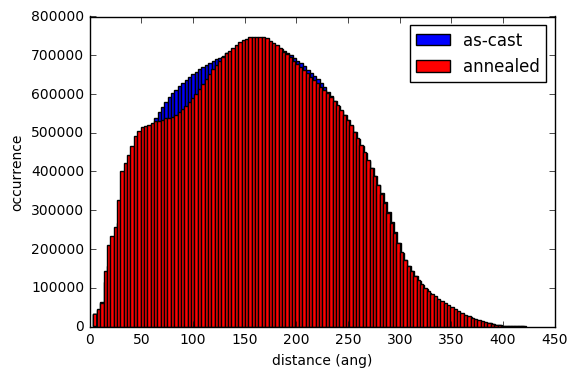

In [11]:
################
#   PLOTTING   #
################
plt.hist(distances_dry,bins=128,color='blue', label = "as-cast") # plt.hist passes it's arguments to np.histogram
plt.hist(distances_ann,bins=128,color='red', label = "annealed")  # plt.hist passes it's arguments to np.histogram
plt.xlabel("distance (ang)")
plt.ylabel("occurrence")
plt.legend()
plt.show()

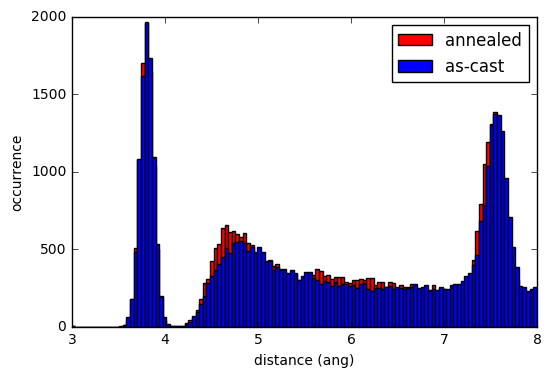

In [12]:
# zoom-in to 3-8 angstrom

plt.hist(distances_ann,range=(3.,8.),bins=128,color='red', label = "annealed")  # plt.hist passes it's arguments to np.histogram
plt.hist(distances_dry,range=(3.,8.),bins=128,color='blue', label = "as-cast") # plt.hist passes it's arguments to np.histogram
plt.xlabel("distance (ang)")
plt.ylabel("occurrence")
plt.xlim(3, 8)
plt.legend()
plt.show()

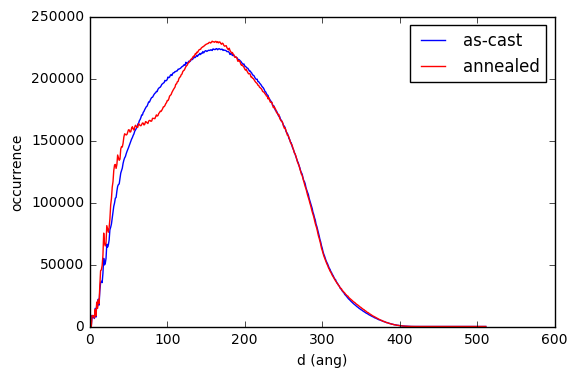

In [13]:
########################################################
# Same plot as above but using the "occurrence" arrays #
########################################################

d = xrange(0,len(occurrence_dry))

plt.plot(d,occurrence_dry,color='blue', label = "as-cast")
plt.plot(d,occurrence_ann,color='red', label = "annealed")
plt.xlabel("d (ang)")
plt.ylabel("occurrence")
plt.legend();
plt.show()

Definition of Fourier Transform:
$$ F(q) = \int_{-\infty}^{+\infty} F(x) e^{-iqx} $$

In 3D (G. Kimminau et al., J. Phys. A Condens. Matter., 2008): $$ \quad I(\mathbf{q}) \propto |F(\mathbf{q})|^2 \propto |\sum_{j=1}^N Z_j \exp(i \mathbf{q} \mathbf{r_j})|^2$$

In 1D: $$ \quad I(q) \propto | F(q) |^2 \propto | \sum_{j=1}^N Z_j \exp(i q x) |^2 $$

In [14]:
####################################
#  Computing the Fourier Transform #
####################################
q_points = 512
occurrence_dry_ft = np.zeros(q_points, dtype=np.complex64)
occurrence_ann_ft = np.zeros(q_points, dtype=np.complex64)

# Define "q_points" equally spaced q points in the interval 2*pi/d_max - 2*pi/d_min (d_max = 256 ang, d_min = 1 ang)
qrange = np.arange(2*np.pi/512,2*np.pi/1,(2*np.pi/1-2*np.pi/512)/q_points)

for q in xrange(0,len(qrange)):
    for x in xrange(0,len(occurrence_ann)):
        occurrence_dry_ft[q] = occurrence_dry_ft[q] + occurrence_dry[x]*np.exp(1j*qrange[q]*x)
        occurrence_ann_ft[q] = occurrence_ann_ft[q] + occurrence_ann[x]*np.exp(1j*qrange[q]*x)

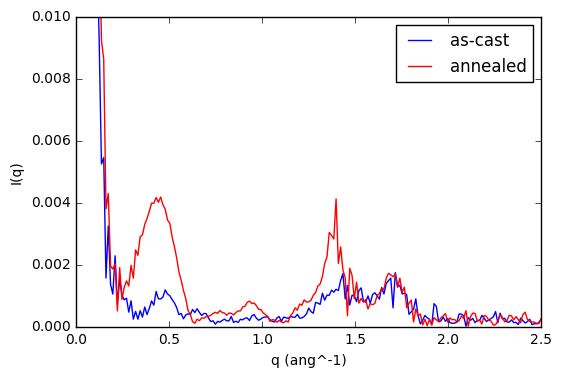

In [15]:
##############
#  Plotting  #
##############

plt.plot(qrange,np.absolute(occurrence_dry_ft/occurrence_dry_ft[0]),color='blue',label='as-cast')
plt.plot(qrange,np.absolute(occurrence_ann_ft/occurrence_ann_ft[0]),color='red',label='annealed')
plt.xlabel("q (ang^-1)")
plt.ylabel("I(q)")
plt.ylim(0,700000)
plt.ylim(0,0.01)
plt.xlim(0,2.5)
plt.legend(loc='upper right')
plt.show()

In [16]:
with open('I_q_ann.dat', 'w') as annout, open('I_q_dry.dat', 'w') as dryout, open('I_q_ann_norm.dat', 'w') as annoutnorm, open('I_q_dry_norm.dat', 'w') as dryoutnorm:
    for i in xrange(0,len(qrange)/2):
        dryoutnorm.write(str(qrange[i]) + "   " + str(np.absolute(occurrence_dry_ft[i]/occurrence_dry_ft[0])) + "\n")
        dryout.write(str(qrange[i]) + "   " + str(np.absolute(occurrence_dry_ft)[i]) + "\n")
        annoutnorm.write(str(qrange[i]) + "   " + str(np.absolute(occurrence_ann_ft[i]/occurrence_ann_ft[0])) + "\n")
        annout.write(str(qrange[i]) + "   " + str(np.absolute(occurrence_ann_ft)[i]) + "\n")

 fit 1: [  3.17010426e+04   4.64311798e-01   8.41253121e-02] 
 fit 2: [  1.27626097e+05   4.26016366e-01   1.00971067e-01] 
 fit 3: [  3.74207114e+04   1.44327043e+00   1.57509036e-01] 
 fit 4: [  7.85344169e+04   1.38549813e+00   9.47288885e-02]


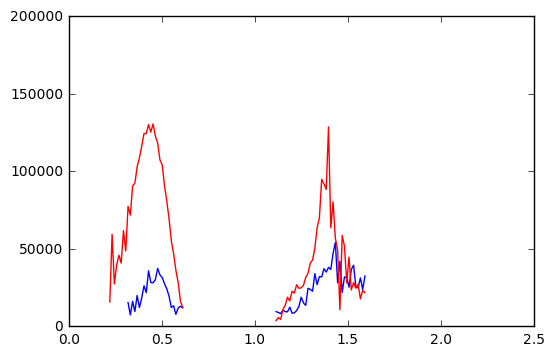

In [17]:
###########
# FITTING #
###########
import numpy as np
from scipy.optimize import curve_fit

def gauss(x, A, x0, sigma):
    return A*np.exp(-(x-x0)**2/(2.*sigma**2))

popt1, pcov1 = curve_fit(gauss, qrange[25:50], np.absolute(occurrence_dry_ft[25:50]),p0=[10000.88347871, 0.5, 0.137802849])
popt2, pcov2 = curve_fit(gauss, qrange[17:50], np.absolute(occurrence_ann_ft[17:50]),p0=[80000.88347871, 0.5, 0.137802849])
popt3, pcov3 = curve_fit(gauss, qrange[90:130], np.absolute(occurrence_dry_ft[90:130]),p0=[10000.88347871, 0.5, 0.137802849])
popt4, pcov4 = curve_fit(gauss, qrange[90:130], np.absolute(occurrence_ann_ft[90:130]),p0=[10000.88347871, 0.5, 0.137802849])

print(" fit 1: " + str(popt1) + " \n" +
      " fit 2: " + str(popt2) + " \n" +
      " fit 3: " + str(popt3) + " \n" +
      " fit 4: " + str(popt4))

plt.plot(qrange[25:50],np.absolute(occurrence_dry_ft[25:50]), color='blue')
plt.plot(qrange[17:50],np.absolute(occurrence_ann_ft[17:50]), color='red')
plt.plot(qrange[90:130],np.absolute(occurrence_dry_ft[90:130]), color='blue')
plt.plot(qrange[90:130],np.absolute(occurrence_ann_ft[90:130]), color='red')
plt.ylim(0,200000)
plt.xlim(0,2.5)
plt.show()

In [18]:
import scipy.integrate

gausslambda = lambda x : A*np.exp(-(x-x0)**2/(2.*sigma**2))

A=3.17010426e+04
x0=4.64311798e-01
sigma=8.41253121e-02

FWHM_dry_peak = 2*np.sqrt(2*np.log(2))*sigma
dry_peak = scipy.integrate.quad(gausslambda,-np.inf,np.inf)
dry_peak_intensity = dry_peak[0]

A=1.27626097e+05
x0=4.26016366e-01
sigma=1.00971067e-01

FWHM_ann_peak = 2*np.sqrt(2*np.log(2))*sigma
ann_peak = scipy.integrate.quad(gausslambda,-np.inf,np.inf)
ann_peak_intensity = ann_peak[0]

print("Lamellar peak in annealed blend at " + str(x0)+ " ang^-1.")

A=3.74207114e+04 
x0= 1.44327043e+00
sigma=1.57509036e-01

FWHM_dry_pi_peak = 2*np.sqrt(2*np.log(2))*sigma
dry_pi_peak = scipy.integrate.quad(gausslambda,-np.inf,np.inf)
dry_pi_peak_intensity = dry_pi_peak[0]

A=7.85344169e+04
x0= 1.38549813e+00
sigma=9.47288885e-02

FWHM_ann_pi_peak = 2*np.sqrt(2*np.log(2))*sigma
ann_pi_peak = scipy.integrate.quad(gausslambda,-np.inf,np.inf)
ann_pi_peak_intensity = ann_pi_peak[0]

print("Stacking peak in annealed blend at " + str(x0)+ " ang^-1.")

Lamellar peak in annealed blend at 0.426016366 ang^-1.
Stacking peak in annealed blend at 1.38549813 ang^-1.


In [19]:
ann_lamellar_dist = 2*np.pi/4.26016366e-01

In [20]:
ann_stacking_dist = 2*np.pi/1.38549813e+00

In [21]:
print("Lamellar distance in annealed blend at " + str(ann_lamellar_dist)+ " ang.")
print("Stacking distance in annealed blend at " + str(ann_stacking_dist)+ " ang.")

Lamellar distance in annealed blend at 14.7486946715 ang.
Stacking distance in annealed blend at 4.53496484126 ang.
